In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import json
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
pd.set_option('display.max_columns', None)


In [272]:
# read in data file and fill rent column
rent_list = []
house = pd.read_csv("../data/prepared_data.csv")
house = house.drop_duplicates(subset=None, keep='first', inplace=False)
price_df = house[['price','rent']]
for index, values in price_df.iterrows():
    if pd.isna(values['rent']) or values['rent'] == 0:
        rent = re.findall(r'\d*[.]?\d+',values['price'])
        if len(rent) >= 1:
            house.loc[index,'rent'] = float(rent[0])
        else:
            house = house.drop(index = index)
            

In [722]:
# filter out properties with abnormal rent prices
house_df = house[house['rent'] > 0].reset_index()
median_price = house_df.groupby(['bathrooms', 'bedrooms', 'carspaces','year','postcode'],as_index = False)['rent'].median('rent')
median_rent = dict()
for index, values in median_price.iterrows():
    year = values['year']
    bathrooms = values['bathrooms']
    bedrooms = values['bedrooms']
    carspaces = values['carspaces']
    postcode = values['postcode']
    key = postcode+year+bathrooms+bedrooms+carspaces
    median_rent[key] = values['rent']
values_list = []
for item,values in house_df.iterrows():
    year = values['year']
    bathrooms = values['bathrooms']
    bedrooms = values['bedrooms']
    carspaces = values['carspaces']
    postcode = values['postcode']
    key = postcode+year+bathrooms+bedrooms+carspaces
    hit = median_rent[key]
    values_list.append(hit)
house_df['median_rent'] = values_list 
house_df = house_df[house_df['rent'] <  3 * house_df['median_rent']]
house_df = house_df[house_df['rent'] >  0.15 * house_df['median_rent']]

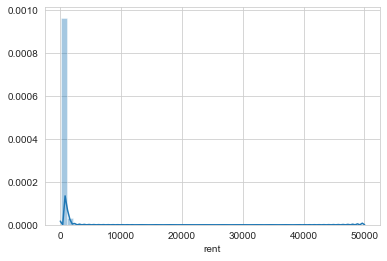

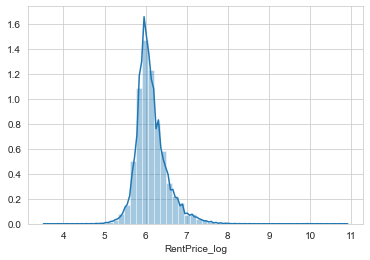

In [723]:
## check if we need to log the rental price as the price might be skewed
x = house_df['rent']
sns.set_style('whitegrid')
sns.distplot(x)
plt.show()

house_df['RentPrice_log'] = np.log(house_df["rent"])
x = house_df['RentPrice_log']
sns.distplot(x)
plt.show()

In [724]:
# convert bond column to 0 and 1
newdf = house_df.drop(['level_0','Unnamed: 0','price','geometry', 'geoLocation','index_right','SA2_maincode_2021','median_rent'], axis=1)
def bond(val):
    if pd.isna(val) or val == 0:
        return 0
    return 1
newdf['has_bond'] = newdf['bond'].apply(bond)
newdf = newdf.drop(['bond'], axis=1)

In [725]:
# Drop unwanted columns
newdf = newdf.drop(['dateUpdated','dateListed'], axis=1)
newdf = newdf.drop(['sum','mean'],axis = 1)
newdf = newdf.drop(['Earners'],axis = 1)
newdf = newdf.drop(['landAreaSqm'],axis = 1)
newdf = newdf.drop('population_increase',axis = 1)
newdf = newdf.drop(['propertyTypes'], axis=1)

In [726]:
# fill columns with nan as 0
newdf = newdf[newdf['bus_distance'] > 0]
for col in newdf.columns[11:26]:
    newdf[col] = newdf[col].fillna(0)

In [727]:
# file median age and median income column that is nan with median number 
for index, values in newdf[pd.isna(newdf['median'])].iterrows():
    income_median = newdf['median'].median()
    newdf.loc[index,'median'] = income_median
for index, values in newdf[pd.isna(newdf['Median_age'])].iterrows():
    Median_age = newdf['Median_age'].median()
    newdf.loc[index,'Median_age'] = Median_age

In [728]:
newdf = newdf[newdf['population'] > 0]
newdf = newdf.drop(['index','longitude', 'latitude'],axis = 1)
newdf.columns

Index(['bathrooms', 'bedrooms', 'carspaces', 'postcode', 'surburb', 'year',
       'month', 'rent', 'bench', 'cafe', 'childcare', 'fast_food',
       'kindergarten', 'parking', 'restaurant', 'place_of_worship', 'school',
       'university', 'garden', 'park', 'playground', 'pitch', 'bus_count',
       'bus_distance', 'school_count', 'school_distance', 'tram_distance',
       'tram_count', 'train_distance', 'train_count', 'hospital_count',
       'shopping_mall_distance', 'shopping_mall_count', 'offence count',
       'incidents recorded', 'Median_age', 'median', 'population',
       'RentPrice_log', 'has_bond'],
      dtype='object')

In [529]:
# calculate house count in each postcode
house_count = pd.DataFrame(newdf['postcode'].value_counts()).reset_index().rename({"index":"postcode",'postcode':'count'},axis = 1)
house_count

,postcode,count
0,3000,9258
1,3029,2886
2,3006,2822
3,3141,2574
4,3008,2550
...,...,...
374,3509,1
375,3379,1
376,3377,1
377,3823,1


In [729]:
# convert median age and population column to int value
newdf['Median_age'] = newdf['Median_age'].apply(lambda x:round(x))
newdf['population'] = newdf['population'].apply(lambda x:round(x))

In [730]:
# combined with cpi dataset
newdf = newdf.merge(house_count, on = 'postcode', how = 'left').fillna(0)
cpi_df = pd.read_csv('../data/cpi.csv').drop({'Unnamed: 0'}, axis = 1)
newdf = newdf.merge(cpi_df, on = 'year')
newdf

,bathrooms,bedrooms,carspaces,postcode,surburb,year,month,rent,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded,Median_age,median,population,RentPrice_log,has_bond,count,cpi
0,1.0,1.0,0.0,3205,south melbourne,2019,1,360.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201,38,66259.675774,12753,5.886104,0,1564,255.65
1,2.0,2.0,1.0,3205,south melbourne,2019,1,725.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201,38,66259.675774,12753,6.586172,0,1564,255.65
2,1.0,2.0,0.0,3205,south melbourne,2019,1,500.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201,38,66259.675774,12753,6.214608,0,1564,255.65
3,1.0,3.0,0.0,3205,south melbourne,2019,1,795.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201,38,66259.675774,12753,6.678342,0,1564,255.65
4,2.0,2.0,0.0,3205,south melbourne,2019,1,825.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201,38,66259.675774,12753,6.715383,0,1564,255.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97651,1.0,1.0,4.0,3460,daylesford,2022,8,475.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,0.705,3,0.896,78.624,0,58.745,0,1,35.093,0,1879,1553,52,47811.172529,10028,6.163315,0,76,271.06
97652,1.0,2.0,0.0,3396,hopetoun,2022,9,180.0,0.0,3.0,0.0,1.0,0.0,4.0,0.0,1.0,3.0,0.0,0.0,5.0,1.0,8.0,1,0.186,2,0.477,315.390,0,294.648,0,1,110.839,0,268,188,37,55477.266641,6407,5.192957,0,3,271.06
97653,1.0,3.0,1.0,3701,dartmouth,2022,5,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230,48,44583.025987,6181,5.634790,0,5,271.06
97654,1.0,3.0,1.0,3701,dartmouth,2022,6,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0,302,230,48,44583.025987,6181,5.669881,0,5,271.06


In [731]:
# combined with gdp dataset
xls = pd.ExcelFile('../data/gdp.xlsx')
df1 = pd.read_excel(xls, 'Data')[36:].drop('Unnamed: 0', axis = 1).rename({'Unnamed: 1':'year','Unnamed: 2':'gdp'},axis = 1).reset_index().drop('index',axis = 1)
gdp_list = df1['gdp']
l = []
m = 0
for i in range(2019,2026):
    l.append([i,gdp_list[m]])
    m = m+1
gdp_df = pd.DataFrame(l, columns=['year','gdp'])
newdf = newdf.merge(gdp_df, on = 'year')
newdf

,bathrooms,bedrooms,carspaces,postcode,surburb,year,month,rent,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded,Median_age,median,population,RentPrice_log,has_bond,count,cpi,gdp
0,1.0,1.0,0.0,3205,south melbourne,2019,1,360.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201,38,66259.675774,12753,5.886104,0,1564,255.65,54254.86
1,2.0,2.0,1.0,3205,south melbourne,2019,1,725.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201,38,66259.675774,12753,6.586172,0,1564,255.65,54254.86
2,1.0,2.0,0.0,3205,south melbourne,2019,1,500.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201,38,66259.675774,12753,6.214608,0,1564,255.65,54254.86
3,1.0,3.0,0.0,3205,south melbourne,2019,1,795.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201,38,66259.675774,12753,6.678342,0,1564,255.65,54254.86
4,2.0,2.0,0.0,3205,south melbourne,2019,1,825.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201,38,66259.675774,12753,6.715383,0,1564,255.65,54254.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97651,1.0,1.0,4.0,3460,daylesford,2022,8,475.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,0.705,3,0.896,78.624,0,58.745,0,1,35.093,0,1879,1553,52,47811.172529,10028,6.163315,0,76,271.06,67464.39
97652,1.0,2.0,0.0,3396,hopetoun,2022,9,180.0,0.0,3.0,0.0,1.0,0.0,4.0,0.0,1.0,3.0,0.0,0.0,5.0,1.0,8.0,1,0.186,2,0.477,315.390,0,294.648,0,1,110.839,0,268,188,37,55477.266641,6407,5.192957,0,3,271.06,67464.39
97653,1.0,3.0,1.0,3701,dartmouth,2022,5,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230,48,44583.025987,6181,5.634790,0,5,271.06,67464.39
97654,1.0,3.0,1.0,3701,dartmouth,2022,6,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0,302,230,48,44583.025987,6181,5.669881,0,5,271.06,67464.39


In [ ]:
newdf = newdf.drop('school', axis = 1)
newdf

In [ ]:
newdf.drop(['RentPrice_log','rent','year','month'], axis=1).columns

In [733]:
# feature selection
y = newdf['RentPrice_log']
X = newdf.drop(['RentPrice_log','rent','year','month','surburb'], axis=1)

selector = SelectKBest(f_regression, k = 28)
selector.fit(X, y)
needcolf = X.columns[selector.get_support()]
colf = []
for i in range(len(needcolf)):
    colf.append(needcolf[i])
colf.append('year')
colf.append('month')
print(colf)

from sklearn.feature_selection import SelectKBest, mutual_info_regression
selector = SelectKBest(mutual_info_regression, k = 28)
selector.fit(X, y)
needcomi = X.columns[selector.get_support()]
comi = []
for i in range(len(needcomi)):
    comi.append(needcomi[i])
comi.append('year')
comi.append('month')
print(comi)

['bathrooms', 'bedrooms', 'carspaces', 'postcode', 'bench', 'cafe', 'childcare', 'fast_food', 'parking', 'restaurant', 'university', 'park', 'playground', 'pitch', 'bus_count', 'school_count', 'tram_distance', 'tram_count', 'train_distance', 'train_count', 'hospital_count', 'shopping_mall_distance', 'shopping_mall_count', 'offence count', 'incidents recorded', 'Median_age', 'median', 'has_bond', 'year', 'month']
['bathrooms', 'bedrooms', 'postcode', 'bench', 'cafe', 'fast_food', 'kindergarten', 'parking', 'restaurant', 'place_of_worship', 'garden', 'park', 'playground', 'pitch', 'bus_count', 'bus_distance', 'school_count', 'school_distance', 'tram_distance', 'tram_count', 'train_distance', 'shopping_mall_distance', 'offence count', 'incidents recorded', 'Median_age', 'median', 'population', 'count', 'year', 'month']


In [734]:
# find common features
common_features = set(colf) & set(comi)
features = []
for i in common_features:
    features.append(i)

In [536]:
group_dict = dict()
for index, values in newdf.iterrows():
    bathroom = str(values['bathrooms'])
    bedroom = str(values['bedrooms'])
    carspaces = str(values['carspaces'])
    postcodes = str(values['postcode'])
    year = str(values['year'])
    month = str(values['month'])
    key = bathroom +' ' + bedroom+' ' + carspaces +' ' +postcodes+' ' +year+' ' + month
    group_list = group_dict.get(key,[])
    group_list.append(values)
    group_dict[key] = group_list

In [537]:
predict_dict = dict()
for index, values in newdf.iterrows():
    bathroom = str(values['bathrooms'])
    bedroom = str(values['bedrooms'])
    carspaces = str(values['carspaces'])
    postcodes = str(values['postcode'])
    key = bathroom+' ' + bedroom+' ' +carspaces+' ' +postcodes
    predict_list = predict_dict.get(key,[])
    predict_list.append(values)
    predict_dict[key] = predict_list

In [599]:
data_list = []
for key, values in group_dict.items():
    rent_price_sum = 0
    bus_distance_sum = 0
    tram_distance_sum = 0
    train_distance_sum = 0
    shopping_mall_distance_sum = 0
    school_distance_sum = 0
    num = len(values)
    for item in values:
        rent_price_sum += item['RentPrice_log']
        # rent_price_sum += item['rent']
        bus_distance_sum += item['bus_distance']
        train_distance_sum += item['train_distance']
        tram_distance_sum += item['tram_distance']
        shopping_mall_distance_sum += item['shopping_mall_distance']
        school_distance_sum += item['school_distance']
    rent_mean = rent_price_sum/num
    bus_mean = bus_distance_sum/num
    train_mean = train_distance_sum/num
    tram_mean = tram_distance_sum/num
    shopping_mall_mean = shopping_mall_distance_sum/num
    school_mean = school_distance_sum/num
    data_list.append([item['bathrooms'],item['bedrooms'],item['carspaces'],item['postcode'],item['year'],item['month'],train_mean,item['train_count'],
    item['hospital_count'],shopping_mall_mean,item['shopping_mall_count'],item['bench'],item['cafe'],item['childcare'],item['fast_food'],item['kindergarten'],item['parking'],item['restaurant']
    ,item['place_of_worship'],school_mean,item['university'], item['garden'], item['park'],item['playground'], item['pitch'], item['offence count'], item['incidents recorded'],bus_mean,item['bus_count'],item['school_count'],school_mean,tram_mean,
    item['tram_count'],rent_mean,item['Median_age'],item['median'],item['population'],item['has_bond'],item['count'],item['cpi'],item['gdp']])

    # data_list.append((item['bathrooms'],item['bedrooms'],item['carspaces'],item['postcode'],item['year'],item['month'],rent_mean,bus_mean,train_mean,tram_mean,shopping_mall_mean))



In [600]:
df = pd.DataFrame(data_list, columns=['bathrooms', 'bedrooms', 'carspaces', 'postcode', 'year',
       'month', 'train_distance', 'train_count',
       'hospital_count', 'shopping_mall_distance', 'shopping_mall_count',
       'bench', 'cafe', 'childcare', 'fast_food', 'kindergarten', 'parking',
       'restaurant', 'place_of_worship', 'school_distance','university', 'garden',
       'park', 'playground', 'pitch', 'offence count','incidents recorded', 'bus_distance',
       'bus_count', 'school_count', 'school_distance', 'tram_distance', 'tram_count', 'rent',
       'Median_age', 'median', 'population', 'has_bond','count','cpi','gdp'])
df

,bathrooms,bedrooms,carspaces,postcode,year,month,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school_distance,university,garden,park,playground,pitch,offence count,incidents recorded,bus_distance,bus_count,school_count,school_distance,tram_distance,tram_count,rent,Median_age,median,population,has_bond,count,cpi,gdp
0,1.0,1.0,0.0,3205,2019,1,2.677111,0,0,1.341556,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.467667,0.0,8.0,16.0,10.0,5.0,22895,17201,0.504111,10,3,0.467667,0.124444,24,5.870629,38,66259.675774,1281,0,1564,255.65,54254.86
1,2.0,2.0,1.0,3205,2019,1,2.374714,0,0,1.422286,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.306429,0.0,8.0,16.0,10.0,5.0,22895,17201,0.730429,10,3,0.306429,0.162143,24,6.406003,38,66259.675774,1281,1,1564,255.65,54254.86
2,1.0,2.0,0.0,3205,2019,1,2.863250,0,0,1.663750,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.361250,0.0,8.0,16.0,10.0,5.0,22895,17201,0.570250,10,3,0.361250,0.151750,24,6.407817,38,66259.675774,12753,0,1564,255.65,54254.86
3,1.0,3.0,0.0,3205,2019,1,3.122500,0,0,1.413500,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.344500,0.0,8.0,16.0,10.0,5.0,22895,17201,0.318500,10,3,0.344500,0.112500,24,6.711789,38,66259.675774,12753,0,1564,255.65,54254.86
4,2.0,2.0,0.0,3205,2019,1,3.534400,0,0,1.388800,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.408600,0.0,8.0,16.0,10.0,5.0,22895,17201,0.137800,10,3,0.408600,0.334000,24,6.712508,38,66259.675774,12753,0,1564,255.65,54254.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45176,1.0,1.0,4.0,3460,2022,8,58.745000,0,1,35.093000,0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,0.896000,0.0,0.0,0.0,1.0,1.0,1879,1553,0.705000,2,3,0.896000,78.624000,0,6.163315,52,47811.172529,10028,0,76,271.06,67464.39
45177,1.0,2.0,0.0,3396,2022,9,294.648000,0,1,110.839000,0,0.0,3.0,0.0,1.0,0.0,4.0,0.0,1.0,0.477000,0.0,0.0,5.0,1.0,8.0,268,188,0.186000,1,2,0.477000,315.390000,0,5.192957,37,55477.266641,6407,0,3,271.06,67464.39
45178,1.0,3.0,1.0,3701,2022,5,233.799000,0,0,68.639000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.219000,0.0,0.0,0.0,0.0,0.0,302,230,52.649000,1,2,10.219000,249.694000,0,5.634790,48,44583.025987,6181,0,5,271.06,67464.39
45179,1.0,3.0,1.0,3701,2022,6,233.877000,0,0,68.662000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.283000,0.0,0.0,0.0,0.0,0.0,302,230,52.627000,1,2,10.283000,249.772000,0,5.669881,48,44583.025987,6181,0,5,271.06,67464.39


In [656]:
data_list_2 = []
for key, values in predict_dict.items():
    rent_price_sum = 0
    bus_distance_sum = 0
    tram_distance_sum = 0
    train_distance_sum = 0
    shopping_mall_distance_sum = 0
    num = len(values)
    for item in values:
        rent_price_sum += item['RentPrice_log']
        # rent_price_sum += item['rent']
        bus_distance_sum += item['bus_distance']
        train_distance_sum += item['train_distance']
        tram_distance_sum += item['tram_distance']
        shopping_mall_distance_sum += item['shopping_mall_distance']
        school_distance_sum += item['school_distance']
    rent_mean = rent_price_sum/num
    bus_mean = bus_distance_sum/num
    train_mean = train_distance_sum/num
    tram_mean = tram_distance_sum/num
    shopping_mall_mean = shopping_mall_distance_sum/num
    school_mean = school_distance_sum/num
    data_list_2.append([item['bathrooms'],item['bedrooms'],item['carspaces'],item['postcode'],train_mean,item['train_count'],
    item['hospital_count'],shopping_mall_mean,item['shopping_mall_count'],item['bench'],item['cafe'],item['childcare'],item['fast_food'],item['kindergarten'],item['parking'],item['restaurant']
    ,item['place_of_worship'],item['university'], item['garden'], item['park'],item['playground'], item['pitch'], item['offence count'], item['incidents recorded'],bus_mean,item['bus_count'],item['school_count'],school_mean,tram_mean,
    item['tram_count'],rent_mean,item['Median_age'],item['median'],item['population'],item['has_bond'],item['count'],item['cpi'],item['gdp']])

In [657]:
df2 = pd.DataFrame(data_list_2, columns=['bathrooms', 'bedrooms', 'carspaces', 'postcode', 'train_distance', 'train_count',
       'hospital_count', 'shopping_mall_distance', 'shopping_mall_count',
       'bench', 'cafe', 'childcare', 'fast_food', 'kindergarten', 'parking',
       'restaurant', 'place_of_worship', 'university', 'garden',
       'park', 'playground', 'pitch', 'offence count','incidents recorded', 'bus_distance',
       'bus_count', 'school_count', 'school_distance','tram_distance', 'tram_count', 'rent',
       'Median_age', 'median', 'population', 'has_bond','count','cpi','gdp'])
df2

,bathrooms,bedrooms,carspaces,postcode,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,university,garden,park,playground,pitch,offence count,incidents recorded,bus_distance,bus_count,school_count,school_distance,tram_distance,tram_count,rent,Median_age,median,population,has_bond,count,cpi,gdp
0,1.0,1.0,0.0,3205,2.372479,0,0,1.530774,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.791281,10,3,322.499912,0.133295,24,5.873056,39,69810.297518,3730,0,1564,271.06,67464.39
1,2.0,2.0,1.0,3205,2.411860,0,0,1.486444,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.738357,10,3,338.495430,0.183377,24,6.379859,39,69810.297518,6528,0,1564,271.06,67464.39
2,1.0,2.0,0.0,3205,2.921702,0,0,1.482578,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.440760,10,3,311.791600,0.208787,24,6.361757,39,69810.297518,11759,0,1564,271.06,67464.39
3,1.0,3.0,0.0,3205,3.144525,0,0,1.418525,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.290175,10,3,1754.254575,0.215850,24,6.570844,39,69810.297518,11759,0,1564,271.06,67464.39
4,2.0,2.0,0.0,3205,3.165820,0,0,1.422120,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.337940,10,3,1403.828640,0.290900,24,6.580744,39,69810.297518,11759,1,1564,271.06,67464.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7630,1.0,1.0,0.0,3730,194.874000,0,1,47.949000,0,4.0,5.0,0.0,0.0,0.0,23.0,2.0,3.0,0.0,1.0,8.0,2.0,4.0,4484,3479,0.139000,52,3,139746.561000,203.750000,0,5.560682,49,47388.455570,8703,0,99,271.06,67464.39
7631,1.0,2.0,0.0,3730,194.874000,0,1,47.949000,0,4.0,5.0,0.0,0.0,0.0,23.0,2.0,3.0,0.0,1.0,8.0,2.0,4.0,4484,3479,0.139000,52,3,139746.659000,203.750000,0,5.991465,49,47388.455570,8703,0,99,271.06,67464.39
7632,1.0,1.0,4.0,3461,57.521000,0,0,31.195000,0,0.0,3.0,0.0,1.0,0.0,18.0,2.0,4.0,0.0,0.0,12.0,2.0,12.0,1222,929,1.020000,13,5,139752.981000,76.880000,0,6.109248,37,55477.266641,10028,0,34,271.06,67464.39
7633,1.0,3.0,0.0,3461,60.908000,0,0,37.292000,0,0.0,3.0,0.0,1.0,0.0,18.0,2.0,4.0,0.0,0.0,12.0,2.0,12.0,1222,929,0.406000,13,5,139753.529000,81.034000,0,6.109248,37,55477.266641,10028,0,34,271.06,67464.39


#### MLP regressor

In [642]:

y = df['rent']
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
nn = MLPRegressor()
nn.fit(X_train_std, y_train)
# TrainScore = nn.score(X_train_std, y_train)
TestScore = nn.score(X_test_std, y_test)
TestScore

0.742038443303719

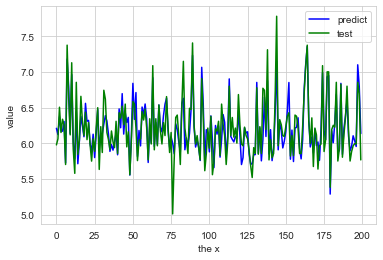

In [643]:
index = range(1,13555)
sample_index = np.random.choice(index, size = 200)
y_predict = nn.predict(X_test_std)
y_p_sample = []
y_t_sample = []
y_test = y_test.reset_index().drop('index', axis = 1)['rent']
for index in sample_index:
#     print(index)
    y_p_sample.append(y_predict[index])
    y_t_sample.append(y_test[index])
import matplotlib.pyplot as plt
y_predict = nn.predict(X_test_std)
plt.plot(range(len(y_p_sample)), y_p_sample, 'b', label="predict")
plt.plot(range(len(y_t_sample)), y_t_sample, 'g', label="test")
plt.legend(loc="upper right")  
plt.xlabel("the x")
plt.ylabel('value')
plt.show()


#### RandomForestRegressor

In [644]:
y = df['rent']
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
rfc = RandomForestRegressor(max_depth=10)  
rfc = rfc.fit(X_train_std, y_train)
print(f'model score on training data: {rfc.score(X_train_std, y_train)}')
print(f'model score on testing data: {rfc.score(X_test_std, y_test)}')

model score on training data: 0.8525943599940224
model score on testing data: 0.7788297616617246


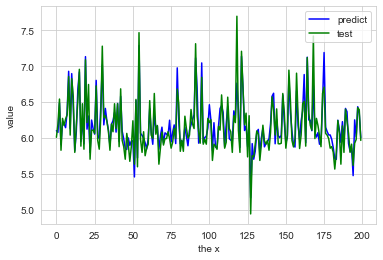

In [645]:
index = range(1,13555)
sample_index = np.random.choice(index, size = 200)
y_predict = rfc.predict(X_test_std)
y_p_sample = []
y_t_sample = []
y_test = y_test.reset_index().drop('index', axis = 1)['rent']
for index in sample_index:
#     print(index)
    y_p_sample.append(y_predict[index])
    y_t_sample.append(y_test[index])
import matplotlib.pyplot as plt
plt.plot(range(len(y_p_sample)), y_p_sample, 'b', label="predict")
plt.plot(range(len(y_t_sample)), y_t_sample, 'g', label="test")
plt.legend(loc="upper right")  
plt.xlabel("the x")
plt.ylabel('value')
plt.show()

In [646]:
# feature importance
perm = PermutationImportance(rfc, random_state=1).fit(X_test_std, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.5191 ± 0.0115,tram_distance
0.4367 ± 0.0166,bedrooms
0.2999 ± 0.0123,bathrooms
0.1075 ± 0.0072,bus_count
0.0901 ± 0.0058,postcode
0.0562 ± 0.0038,median
0.0536 ± 0.0017,train_distance
0.0182 ± 0.0060,year
0.0165 ± 0.0028,tram_count
0.0151 ± 0.0067,shopping_mall_distance


In [ ]:
# r = permutation_importance(rfc, X_train_std, y_train, n_repeats = 5, random_state = 0)
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{df_combined.columns[i]:<8}"
#         f"{r.importances_mean[i]:.3f}"
#         f" +/- {r.importances_std[i]:.3f}")

#### XGB Regressor

<Axes:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

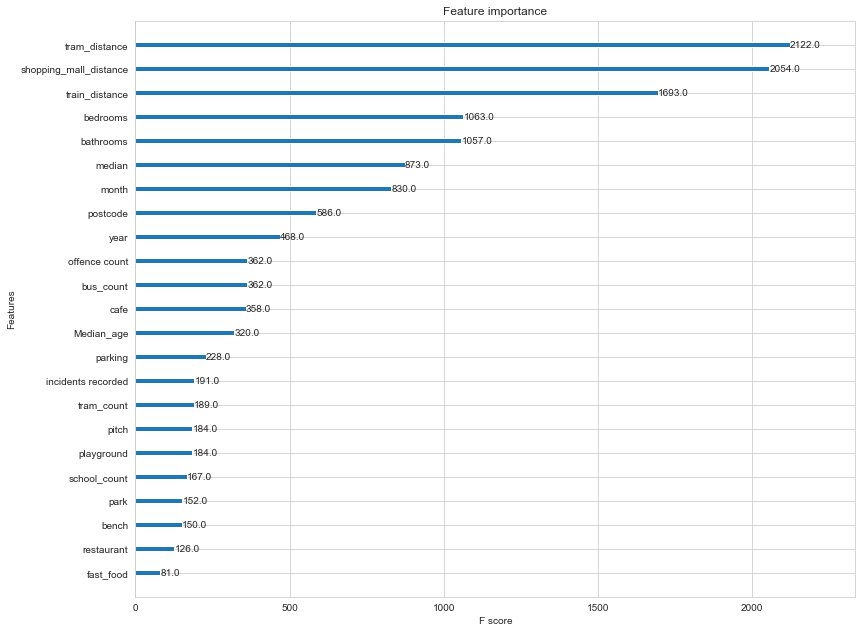

In [647]:
y = df['rent']
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
xgbc = xgb.XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 4,
)
xgbc.fit(
    X_train, 
    y_train
)
fea_imp = xgbc.feature_importances_
fig = plt.figure(figsize = (10, 8))
ax = fig.add_axes([0,0,1,1])
xgb.plot_importance(xgbc, ax)

In [648]:
xgbc.score(X_test, y_test)

0.7851692204745835

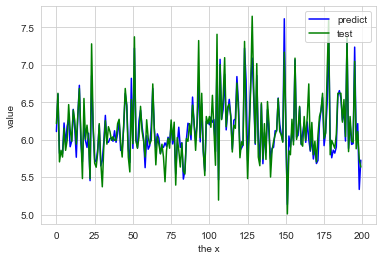

In [649]:
index = range(1,13555)
sample_index = np.random.choice(index, size = 200)
y_predict = xgbc.predict(X_test)
y_p_sample = []
y_t_sample = []
y_test = y_test.reset_index().drop('index', axis = 1)['rent']
for index in sample_index:
#     print(index)
    y_p_sample.append(y_predict[index])
    y_t_sample.append(y_test[index])
import matplotlib.pyplot as plt
plt.plot(range(len(y_p_sample)), y_p_sample, 'b', label="predict")
plt.plot(range(len(y_t_sample)), y_t_sample, 'g', label="test")
plt.legend(loc="upper right")  
plt.xlabel("the x")
plt.ylabel('value')
plt.show()

#### Decision tree Regressor

In [650]:
from sklearn.tree import DecisionTreeRegressor
y = df['rent']
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
dt = DecisionTreeRegressor()
dt.fit(X_train_std, y_train)
score = dt.score(X_test_std, y_test)
score

0.5419229818261195

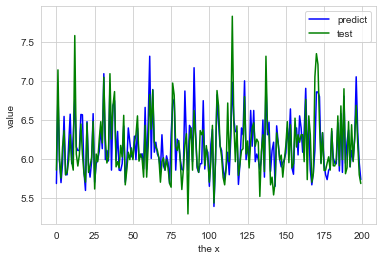

In [651]:
index = range(1,13555)
sample_index = np.random.choice(index, size = 200)
y_predict = dt.predict(X_test_std)
y_p_sample = []
y_t_sample = []
y_test = y_test.reset_index().drop('index', axis = 1)['rent']
for index in sample_index:
    y_p_sample.append(y_predict[index])
    y_t_sample.append(y_test[index])
plt.plot(range(len(y_p_sample)), y_p_sample, 'b', label="predict")
plt.plot(range(len(y_t_sample)), y_t_sample, 'g', label="test")
plt.legend(loc="upper right")  
plt.xlabel("the x")
plt.ylabel('value')
plt.show()

#### LinearRegression

In [652]:
from sklearn.linear_model import LinearRegression
y = df['rent']
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
lr = LinearRegression()
lr.fit(X_train_std, y_train)
score = lr.score(X_test_std, y_test)
score


0.5271667788539116

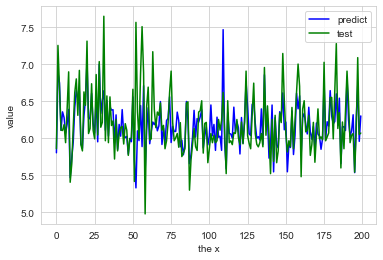

In [653]:
index = range(1,13555)
sample_index = np.random.choice(index, size = 200)
y_predict = lr.predict(X_test_std)
y_p_sample = []
y_t_sample = []
y_test = y_test.reset_index().drop('index', axis = 1)['rent']
for index in sample_index:
    y_p_sample.append(y_predict[index])
    y_t_sample.append(y_test[index])
plt.plot(range(len(y_p_sample)), y_p_sample, 'b', label="predict")
plt.plot(range(len(y_t_sample)), y_t_sample, 'g', label="test")
plt.legend(loc="upper right")  
plt.xlabel("the x")
plt.ylabel('value')
plt.show()

In [ ]:
# df2 = df2.drop([['population', 'cpi', 'gdp']], axis = 1)
df2 = df2.drop(['population', 'cpi', 'gdp'], axis = 1)

In [739]:
df3 = pd.DataFrame()
for year in range(2023,2026):
    for month in range(1,13):
        tmp_df = df2.copy()
        year_list = [year]*len(df2)
        month_list = [month]*len(df2)
        tmp_df['year'] = year_list
        tmp_df['month'] = month_list
        df3= pd.concat([df3,tmp_df])
df3 = df3.reset_index().drop(['index'],axis = 1)
df3

,bathrooms,bedrooms,carspaces,postcode,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,university,garden,park,playground,pitch,offence count,incidents recorded,bus_distance,bus_count,school_count,school_distance,tram_distance,tram_count,rent,Median_age,median,has_bond,count,year,month
0,1.0,1.0,0.0,3205,2.372479,0,0,1.530774,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.791281,10,3,322.499912,0.133295,24,5.873056,39,69810.297518,0,1564,2023,1
1,2.0,2.0,1.0,3205,2.411860,0,0,1.486444,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.738357,10,3,338.495430,0.183377,24,6.379859,39,69810.297518,0,1564,2023,1
2,1.0,2.0,0.0,3205,2.921702,0,0,1.482578,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.440760,10,3,311.791600,0.208787,24,6.361757,39,69810.297518,0,1564,2023,1
3,1.0,3.0,0.0,3205,3.144525,0,0,1.418525,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.290175,10,3,1754.254575,0.215850,24,6.570844,39,69810.297518,0,1564,2023,1
4,2.0,2.0,0.0,3205,3.165820,0,0,1.422120,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.337940,10,3,1403.828640,0.290900,24,6.580744,39,69810.297518,1,1564,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274855,1.0,1.0,0.0,3730,194.874000,0,1,47.949000,0,4.0,5.0,0.0,0.0,0.0,23.0,2.0,3.0,0.0,1.0,8.0,2.0,4.0,4484,3479,0.139000,52,3,139746.561000,203.750000,0,5.560682,49,47388.455570,0,99,2025,12
274856,1.0,2.0,0.0,3730,194.874000,0,1,47.949000,0,4.0,5.0,0.0,0.0,0.0,23.0,2.0,3.0,0.0,1.0,8.0,2.0,4.0,4484,3479,0.139000,52,3,139746.659000,203.750000,0,5.991465,49,47388.455570,0,99,2025,12
274857,1.0,1.0,4.0,3461,57.521000,0,0,31.195000,0,0.0,3.0,0.0,1.0,0.0,18.0,2.0,4.0,0.0,0.0,12.0,2.0,12.0,1222,929,1.020000,13,5,139752.981000,76.880000,0,6.109248,37,55477.266641,0,34,2025,12
274858,1.0,3.0,0.0,3461,60.908000,0,0,37.292000,0,0.0,3.0,0.0,1.0,0.0,18.0,2.0,4.0,0.0,0.0,12.0,2.0,12.0,1222,929,0.406000,13,5,139753.529000,81.034000,0,6.109248,37,55477.266641,0,34,2025,12


In [740]:
f = open("../data/year_school_address.txt")
data = json.load(f)
new_school = pd.DataFrame(data, columns=['year','link','address'])
def get_postcode(add):
    add_list = add.split(' ')
    return add_list[-1]
new_school['postcode'] = new_school['address'].apply(get_postcode)

In [741]:
school_dict = {}
for index, value in new_school.iterrows():
    year = value['year']
    postcode = value['postcode']
    key = year + ' ' + postcode
    if key not in school_dict.keys():
        school_dict[key] = 1
    else:
        school_dict[key] += 1
for index, values in df3.iterrows():
    year = str(values['year'])
    postcode = str(values['postcode'])
    key = year + ' ' + postcode
    if key in school_dict.keys():
        school_values = values['school']
        df3.loc[index,'school'] = school_values + school_dict[key]
df3 = df3.merge(gdp_df, on = 'year', how='left')
df3 = df3.merge(house_count,  on = 'postcode', how = 'left').fillna(0)
df3

,bathrooms,bedrooms,carspaces,postcode,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,university,garden,park,playground,pitch,offence count,incidents recorded,bus_distance,bus_count,school_count,school_distance,tram_distance,tram_count,rent,Median_age,median,has_bond,count_x,year,month,gdp,count_y
0,1.0,1.0,0.0,3205,2.372479,0,0,1.530774,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.791281,10,3,322.499912,0.133295,24,5.873056,39,69810.297518,0,1564,2023,1,69717.12,1564
1,2.0,2.0,1.0,3205,2.411860,0,0,1.486444,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.738357,10,3,338.495430,0.183377,24,6.379859,39,69810.297518,0,1564,2023,1,69717.12,1564
2,1.0,2.0,0.0,3205,2.921702,0,0,1.482578,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.440760,10,3,311.791600,0.208787,24,6.361757,39,69810.297518,0,1564,2023,1,69717.12,1564
3,1.0,3.0,0.0,3205,3.144525,0,0,1.418525,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.290175,10,3,1754.254575,0.215850,24,6.570844,39,69810.297518,0,1564,2023,1,69717.12,1564
4,2.0,2.0,0.0,3205,3.165820,0,0,1.422120,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.337940,10,3,1403.828640,0.290900,24,6.580744,39,69810.297518,1,1564,2023,1,69717.12,1564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274855,1.0,1.0,0.0,3730,194.874000,0,1,47.949000,0,4.0,5.0,0.0,0.0,0.0,23.0,2.0,3.0,0.0,1.0,8.0,2.0,4.0,4484,3479,0.139000,52,3,139746.561000,203.750000,0,5.560682,49,47388.455570,0,99,2025,12,74353.74,99
274856,1.0,2.0,0.0,3730,194.874000,0,1,47.949000,0,4.0,5.0,0.0,0.0,0.0,23.0,2.0,3.0,0.0,1.0,8.0,2.0,4.0,4484,3479,0.139000,52,3,139746.659000,203.750000,0,5.991465,49,47388.455570,0,99,2025,12,74353.74,99
274857,1.0,1.0,4.0,3461,57.521000,0,0,31.195000,0,0.0,3.0,0.0,1.0,0.0,18.0,2.0,4.0,0.0,0.0,12.0,2.0,12.0,1222,929,1.020000,13,5,139752.981000,76.880000,0,6.109248,37,55477.266641,0,34,2025,12,74353.74,34
274858,1.0,3.0,0.0,3461,60.908000,0,0,37.292000,0,0.0,3.0,0.0,1.0,0.0,18.0,2.0,4.0,0.0,0.0,12.0,2.0,12.0,1222,929,0.406000,13,5,139753.529000,81.034000,0,6.109248,37,55477.266641,0,34,2025,12,74353.74,34


In [742]:
df3 = df3[X_train.columns]
df3

,cafe,month,bus_count,offence count,tram_count,playground,tram_distance,parking,bathrooms,bedrooms,year,incidents recorded,pitch,park,median,postcode,restaurant,bench,Median_age,shopping_mall_distance,school_count,train_distance,fast_food
0,41.0,1,10,22895,24,10.0,0.133295,30.0,1.0,1.0,2023,17201,5.0,16.0,69810.297518,3205,40.0,11.0,39,1.530774,3,2.372479,17.0
1,41.0,1,10,22895,24,10.0,0.183377,30.0,2.0,2.0,2023,17201,5.0,16.0,69810.297518,3205,40.0,11.0,39,1.486444,3,2.411860,17.0
2,41.0,1,10,22895,24,10.0,0.208787,30.0,1.0,2.0,2023,17201,5.0,16.0,69810.297518,3205,40.0,11.0,39,1.482578,3,2.921702,17.0
3,41.0,1,10,22895,24,10.0,0.215850,30.0,1.0,3.0,2023,17201,5.0,16.0,69810.297518,3205,40.0,11.0,39,1.418525,3,3.144525,17.0
4,41.0,1,10,22895,24,10.0,0.290900,30.0,2.0,2.0,2023,17201,5.0,16.0,69810.297518,3205,40.0,11.0,39,1.422120,3,3.165820,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274855,5.0,12,52,4484,0,2.0,203.750000,23.0,1.0,1.0,2025,3479,4.0,8.0,47388.455570,3730,2.0,4.0,49,47.949000,3,194.874000,0.0
274856,5.0,12,52,4484,0,2.0,203.750000,23.0,1.0,2.0,2025,3479,4.0,8.0,47388.455570,3730,2.0,4.0,49,47.949000,3,194.874000,0.0
274857,3.0,12,13,1222,0,2.0,76.880000,18.0,1.0,1.0,2025,929,12.0,12.0,55477.266641,3461,2.0,0.0,37,31.195000,5,57.521000,1.0
274858,3.0,12,13,1222,0,2.0,81.034000,18.0,1.0,3.0,2025,929,12.0,12.0,55477.266641,3461,2.0,0.0,37,37.292000,5,60.908000,1.0


In [743]:
# prediction
predict_std = sc.transform(df3)
rent_list = rfc.predict(predict_std)
df3['predicted_rent'] = rent_list

/var/folders/rx/_11wjxvj4hx57z74nvgkbvpr0000gn/T/ipykernel_29165/4163586444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['predicted_rent'] = rent_list


In [744]:
df3['predicted_rent_original'] = df3['predicted_rent'].apply(lambda x: np.exp(x))

/var/folders/rx/_11wjxvj4hx57z74nvgkbvpr0000gn/T/ipykernel_29165/3023380667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['predicted_rent_original'] = df3['predicted_rent'].apply(lambda x: np.exp(x))


In [719]:
suburb_postcode_df = house[['surburb','postcode']].drop_duplicates()
suburb_postcode_df

,surburb,postcode
0,south melbourne,3205
48,albert park,3206
152,port melbourne,3207
256,melbourne,3004
939,southbank,3006
...,...,...
113152,camperdown,3260
113154,tallangatta,3700
113155,eskdale,3701
113156,dartmouth,3701


In [764]:
postcode_suburb_list = dict()
for index, value in suburb_postcode_df.iterrows():
    postcode = value['postcode']
    suburb = value['surburb']
    key = str(postcode)
    value_list = postcode_suburb_list.get(postcode,[])
    value_list.append(value)
    postcode_suburb_list[postcode] = value_list

In [797]:
p_list = []
for index, data in df3.iterrows():
    postcode = str(int(data['postcode']))
    df = postcode_suburb_list.get(int(postcode))
    if df is None:
        p_list.append(None)
    else:
        suburb_l = []
        for i in range(len(df)):
            suburb_l.append(df[i]['surburb'])

        p_list.append(suburb_l)
df3['suburb'] = p_list

In [801]:
df3.to_csv('../data/curated/predicted_df_combined.csv')
df3_combinded = pd.read_csv('../data/curated/predicted_df_combined.csv').drop(['Unnamed: 0'], axis = 1)

In [802]:
suburb_mean_rent = pd.DataFrame(df3_combinded.groupby(['year','postcode']).mean('predicted_rent_original')['predicted_rent_original']).reset_index().rename({'predicted_rent':'rent'}, axis = 1)
suburb_mean_rent = suburb_mean_rent.rename({'predicted_rent_original':'rent'}, axis = 1)
suburb_mean_rent

,year,postcode,rent
0,2023,3000,837.555278
1,2023,3003,613.843381
2,2023,3004,923.297614
3,2023,3006,786.304324
4,2023,3008,834.496513
...,...,...,...
1132,2025,3977,437.587731
1133,2025,3978,487.945355
1134,2025,3980,502.005678
1135,2025,3981,484.243182


In [803]:
history_rent = pd.DataFrame(newdf.groupby(['year','postcode']).mean('rent')['rent']).reset_index().rename({'surburb':'suburb'}, axis = 1)
history_rent

,year,postcode,rent
0,2019,3000,593.347591
1,2019,3003,536.830986
2,2019,3004,684.977961
3,2019,3006,797.677819
4,2019,3008,640.079954
...,...,...,...
1308,2022,3976,426.744186
1309,2022,3977,456.101695
1310,2022,3978,493.700000
1311,2022,3981,600.000000


In [804]:
combined_rent = pd.concat([history_rent, suburb_mean_rent])
combined_rent = combined_rent.sort_values(by = ['postcode','year']).reset_index().drop('index', axis = 1)
combined_rent

,year,postcode,rent
0,2019,3000,593.347591
1,2020,3000,482.208958
2,2021,3000,397.789688
3,2022,3000,500.921852
4,2023,3000,837.555278
...,...,...,...
2445,2021,3984,373.333333
2446,2022,3984,520.000000
2447,2023,3984,536.616035
2448,2024,3984,536.616035


In [805]:
postcode_value = pd.DataFrame(combined_rent['postcode'].drop_duplicates())

In [806]:
l = []
for i in postcode_value['postcode']:
    for j in range(2019, 2026):
        l.append([i,j])
    

In [807]:
l = pd.DataFrame(l, columns=['postcode','year'])

In [808]:
com = combined_rent.merge(l, on = ['year','postcode'], how = 'right')
com = com.sort_values(by = ['postcode','year']).reset_index().drop('index', axis = 1)
com

,year,postcode,rent
0,2019,3000,593.347591
1,2020,3000,482.208958
2,2021,3000,397.789688
3,2022,3000,500.921852
4,2023,3000,837.555278
...,...,...,...
2648,2021,3984,373.333333
2649,2022,3984,520.000000
2650,2023,3984,536.616035
2651,2024,3984,536.616035


In [510]:
# rent_dict = dict()
# for index, values in combined_rent.iterrows():
#     year = str(int(values['year']))
#     postcode = str(int(values['postcode']))
#     key = year + ' '+ postcode
#     rent_dict[key] = values['rent']


In [511]:
# for index, value in com.iterrows():
#     if np.isnan(value['rent']):
#         year = int(value['year'])
#         postcode = int(value['postcode'])
#         if year == 2019:
#             continue
#         year = year - 1
#         key = str(year) + ' '+ str(postcode)
#         if key in rent_dict.keys():
#             com.loc[index,'rent'] = rent_dict[key]
#         else:
#             if year == 2019:
#                 continue
#             year = year - 1
#             key = str(year) + ' '+ str(postcode)
#             if key in rent_dict.keys():
#                 com.loc[index,'rent'] = rent_dict[key]
#             else:
#                 if year == 2019:
#                     continue
#                 year = year - 1
#                 key = str(year) + ' '+ str(postcode)
#                 if key in rent_dict.keys():
#                     com.loc[index,'rent'] = rent_dict[key]
                


In [809]:
com

,year,postcode,rent
0,2019,3000,593.347591
1,2020,3000,482.208958
2,2021,3000,397.789688
3,2022,3000,500.921852
4,2023,3000,837.555278
...,...,...,...
2648,2021,3984,373.333333
2649,2022,3984,520.000000
2650,2023,3984,536.616035
2651,2024,3984,536.616035


In [810]:
yearly_growth_list = []
for name, group in com.groupby('postcode'):   
    group['lag(rent,1)'] = group['rent'].shift(1)
    growth_dict = dict()
    growth_dict['postcode'] = name
    for index, value in group.iterrows():
        rent = value['rent']
        lag = value['lag(rent,1)']
        rate = 0
        if pd.isna(lag):
            rete = None
        else:
            rate = (rent-lag)/lag *100
        growth_dict['year'+ ' ' + str(int(value['year']))] = rate
    yearly_growth_list.append(growth_dict)

In [816]:
rate_df = pd.DataFrame(yearly_growth_list)
top_10 = rate_df.sort_values(by = ['year 2023','year 2024', 'year 2025'],ascending=False,na_position='last')[:10]
p_list = []
for index, data in top_10.iterrows():
    postcode = str(int(data['postcode']))
    df = postcode_suburb_list.get(int(postcode))
    if df is None:
        p_list.append(None)
    else:
        suburb_l = []
        for i in range(len(df)):
            suburb_l.append(df[i]['surburb'])

        p_list.append(suburb_l)
# top_10 = top_10.merge(suburb_postcode_df, on = 'postcode', how = 'left').drop_duplicates(subset='postcode')
top_10['surburb'] = p_list

In [817]:
top_10

,postcode,year 2019,year 2020,year 2021,year 2022,year 2023,year 2024,year 2025,surburb
293,3752,0,-75.954155,-1.354047,7.516247,103.771627,0.0,0.0,[south morang]
111,3141,0,-7.370786,-17.015542,1.606316,96.388398,0.0,0.0,[south yarra]
151,3184,0,-15.859649,2.836584,-8.485904,91.063013,0.0,0.0,[elwood]
92,3122,0,-0.291444,-21.223374,7.089905,86.779071,0.0,0.0,[hawthorn]
149,3182,0,-4.769585,-9.877657,1.303042,81.830339,0.0,0.0,"[st kilda, st kilda west]"
270,3595,0,0.000000,NaN,0.000000,75.555021,0.0,0.0,[nyah west]
152,3185,0,-17.109188,-0.446751,1.131232,69.875336,0.0,0.0,"[elsternwick, gardenvale, ripponlea]"
0,3000,0,-18.730780,-17.506782,25.926304,67.202783,0.0,0.0,[melbourne]
150,3183,0,-5.342078,-5.461970,6.208149,65.382162,0.0,0.0,"[st kilda east, balaclava]"
230,3396,0,0.000000,0.000000,0.000000,64.853951,0.0,0.0,[hopetoun]


In [251]:
top_10.to_csv('../data/curated/top_ten.csv')

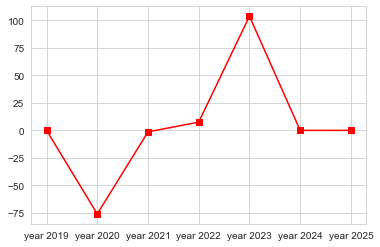

In [813]:
x = top_10.columns[1:-1]
y1 = top_10.iloc[0][1:-1]
y2 = top_10.iloc[1][1:-1]
y3 = top_10.iloc[2][1:-1]
y4 = top_10.iloc[3][1:-1]
y5 = top_10.iloc[4][1:-1]
y6 = top_10.iloc[5][1:-1]
y7 = top_10.iloc[6][1:-1]
y8 = top_10.iloc[7][1:-1]
y9 = top_10.iloc[8][1:-1]
y10 = top_10.iloc[9][1:-1]
plt.plot(x,y1,'s-',color = 'r',label="ATT-RLSTM")

In [1338]:
# index = []
# for name, group in newdf.groupby('surburb'):
#     rent = group['rent'].median()
#     median_income = group['median'].median()
#     house_cost = rent/(median_income + 0.00001)
#     bus = int(list(group['bus_count'].drop_duplicates())[0]) * group['bus_distance'].mean()
#     tram = int(list(group['tram_count'].drop_duplicates())[0]) * group['tram_distance'].mean()
#     train = int(list(group['train_count'].drop_duplicates())[0]) * group['train_distance'].mean()
#     shopping_mall = int(list(group['shopping_mall_count'].drop_duplicates())[0]) * group['shopping_mall_distance'].mean()
#     eating = list(group['cafe'].drop_duplicates())[0] + list(group['fast_food'].drop_duplicates())[0] + list(group['restaurant'].drop_duplicates())[0]
#     enviornment = list(group['garden'].drop_duplicates())[0] + list(group['park'].drop_duplicates())[0] + list(group['playground'].drop_duplicates())[0]+list(group['pitch'].drop_duplicates())[0]+list(group['place_of_worship'].drop_duplicates())[0]
#     education = list(group['school_count'].drop_duplicates())[0] + list(group['childcare'].drop_duplicates())[0] + list(group['kindergarten'].drop_duplicates())[0]+list(group['university'].drop_duplicates())[0]
#     safty = list(group['offence count'].drop_duplicates())[0] + list(group['incidents recorded'].drop_duplicates())[0]
#     health_care = list(group['hospital_count'].drop_duplicates())[0]
#     livable_index = house_cost * 0.2 + (bus+tram+train) * 0.2 + shopping_mall* 0.05 + eating*0.05 + education*0.1+ enviornment*0.2 + health_care*0.1 + safty*0.1
#     index.append([name,livable_index])
# index_df = pd.DataFrame(index, columns=['suburb','index'])

In [1339]:
# rank = index_df.sort_values(by = 'index', ascending=False)
# rank

,suburb,index
199,dandenong south,17992.420788
198,dandenong north,17972.066439
197,dandenong,17971.954135
277,frankston south,14339.286487
275,frankston,14335.916200
...,...,...
87,boort,47.441622
94,branxholme,31.331465
747,woorinen south,30.214626
695,underbool,17.478154


In [818]:
details = []
for name, group in newdf.groupby('surburb'):
    rent = group['rent'].median()
    median_income = group['median'].fillna(0).median()
    house_cost = median_income/rent

    bus = int(group['bus_count'].iloc[0]) * group['bus_distance'].mean()
    train = int(group['train_count'].iloc[0]) * group['train_distance'].mean()
    tram = int(group['tram_count'].iloc[0]) * group['tram_distance'].mean()

    transport = bus + tram + train
    
    shopping_mall = int(group['shopping_mall_count'].iloc[0]) * group['shopping_mall_distance'].mean()
    eating = int(group['cafe'].iloc[0]) + int(group['fast_food'].iloc[0]) + int(group['restaurant'].iloc[0])
    
    enviornment = int(group['garden'].iloc[0]) + int(group['park'].iloc[0]) + int(group['playground'].iloc[0]) + int(group['pitch'].iloc[0])
    + int(group['place_of_worship'].iloc[0])
        
    education =  int(group['school_count'].iloc[0]) + int(group['childcare'].iloc[0]) + int(group['kindergarten'].iloc[0]) + int(group['university'].iloc[0])
        
    safty = int(group['offence count'].iloc[0]) + int(group['incidents recorded'].iloc[0]) 
    
    health_care = int(group['hospital_count'].iloc[0])
    details.append([name,house_cost,transport,shopping_mall,eating,enviornment,education,safty,health_care])
details_df = pd.DataFrame(details, columns=['suburb','house_cost','transport_cost','shopping_mall','eating','enviornment','education','safty','health_care'])
details_df['safty'] = 1/details_df['safty']
details_df

,suburb,house_cost,transport_cost,shopping_mall,eating,enviornment,education,safty,health_care
0,abbotsford,154.442371,12.944229,0.000000,2,307,3,0.000041,0
1,aberfeldie,133.875252,39.982432,1.658216,89,98,13,0.000037,1
2,aintree,126.084697,4.513481,0.000000,31,122,5,0.000137,0
3,aireys inlet,154.103518,0.674667,0.000000,9,32,1,0.001208,0
4,airport west,154.040486,18.282842,0.000000,3,77,7,0.000038,0
...,...,...,...,...,...,...,...,...,...
760,yarrambat,117.704970,3.989250,0.000000,2,24,1,0.000947,0
761,yarraville,144.184263,9.629931,0.000000,18,121,7,0.000066,0
762,yarrawonga,131.254404,13.195699,0.000000,7,15,3,0.000126,1
763,yarrawonga south,86.160828,365.092000,0.000000,7,15,3,0.000126,1


In [823]:
# normalization
for i in range(8):
    j = i+1
    max = details_df.iloc[:,j].max()
    details_df.iloc[:,j] = details_df.iloc[:,j] / max
# score caculating
livable_index = details_df['house_cost'] * 0.3 + details_df['transport_cost'] * 0.16 + details_df['shopping_mall']*0.08 
+ details_df['eating']*0.1 + details_df['enviornment']*0.08+details_df['education']*0.05 +details_df['safty']*0.15+ details_df['health_care']*0.08
details_df['livable_index'] = livable_index

In [825]:
livable = details_df.sort_values(by = 'livable_index', ascending=False)[:10]
livable
# livable.to_csv('../data/curated/livable.csv')

,suburb,house_cost,transport_cost,shopping_mall,eating,enviornment,education,safty,health_care,livable_index
130,cape bridgewater,0.813369,0.470952,0.00000,0.005181,0.029825,0.212766,0.005629,0.166667,0.319363
286,gerrigerrup,1.000000,0.021095,0.00000,0.005181,0.007018,0.042553,0.258333,0.166667,0.303375
341,iguana creek,0.502364,0.415770,1.00000,0.028497,0.027193,0.255319,0.003114,0.166667,0.297232
678,toolleen,0.438143,1.000000,0.00000,0.010363,0.086842,0.255319,0.007167,0.000000,0.291443
334,hopetoun,0.967978,0.000086,0.00000,0.010363,0.012281,0.042553,0.271930,0.166667,0.290407
744,woodglen,0.499157,0.374096,0.91393,0.028497,0.027193,0.255319,0.003114,0.166667,0.282717
736,willow grove,0.567743,0.686079,0.00000,0.044041,0.097368,0.404255,0.002146,0.000000,0.280096
490,mount richmond,0.530679,0.697370,0.00000,0.005181,0.029825,0.212766,0.005629,0.166667,0.270783
494,murtoa,0.893518,0.000247,0.00000,0.002591,0.013158,0.042553,0.104818,0.000000,0.268095
194,curdievale,0.871180,0.016684,0.00000,0.005181,0.014035,0.042553,0.083671,0.166667,0.264024
